In [22]:
#Bibliotecas
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
#from scipy.fft import dct as scipy_dct
from scipy.fftpack import dct as scipy_dct
from scipy.fftpack import idct as scipy_idct

In [23]:
def rle_decode(data, rows, columns):    
    decoding = np.empty([rows, columns])

    iterator = 0
    go_down = None
    change_direction = False

    repeat = data[iterator]
    iterator += 1

    next_position = [0, 0]
    last_position = (rows - 1, columns - 1)

    data_len = len(data)
    while True:
        value = data[iterator]

        if repeat == 0:
            iterator += 1

            if iterator == data_len:
                break

            repeat = data[iterator]
            iterator += 1

            continue

        decoding[next_position[0], next_position[1]] = value
        repeat -= 1

        if change_direction:
            change_direction = False

            if next_position[1] == last_position[1] or next_position[0] == 0:
                next_position[0] += 1
                next_position[1] -= 1

                go_down = True
            elif next_position[1] == 0 or next_position[0] == last_position[0]:
                next_position[0] -= 1
                next_position[1] += 1

                go_down = False
        elif next_position[0] == 0 or next_position[0] == last_position[0]:
            next_position[1] += 1

            change_direction = True
        elif next_position[1] == 0 or next_position[1] == last_position[1]:
            next_position[0] += 1

            change_direction = True
        else:
            next_position[0] += 1 * (go_down and 1 or -1)
            next_position[1] += 1 * (go_down and -1 or 1)

    return decoding

In [24]:
def rle_encode(data, rows, columns):    
    encoding = []

    prev = data[0, 0]
    count = 1

    go_down = None
    change_direction = True

    next_position = [0, 1]
    last_position = (rows - 1, columns - 1)

    while next_position[0] <= last_position[0] and next_position[1] <= last_position[1]:
        value = data[next_position[0], next_position[1]]

        if value != prev:
            encoding.append(count)
            encoding.append(prev)
                
            count = 1
            prev = value
        else:
            count += 1

        if change_direction:
            change_direction = False

            if next_position[1] == last_position[1] or next_position[0] == 0:
                next_position[0] += 1
                next_position[1] -= 1

                go_down = True
            elif next_position[1] == 0 or next_position[0] == last_position[0]:
                next_position[0] -= 1
                next_position[1] += 1

                go_down = False
        elif next_position[0] == 0 or next_position[0] == last_position[0]:
            next_position[1] += 1

            change_direction = True
        elif next_position[1] == 0 or next_position[1] == last_position[1]:
            next_position[0] += 1

            change_direction = True
        else:
            next_position[0] += 1 * (go_down and 1 or -1)
            next_position[1] += 1 * (go_down and -1 or 1)

    encoding.append(count)
    encoding.append(prev)

    return encoding

In [25]:
def quantization(img, quantization_table):
    img_quantized = np.zeros(shape = img.shape)
    
    for i in range(8):
        for j in range(8):
            img_quantized[i, j] = round(img[i, j] / quantization_table[i, j])
            
    return img_quantized

In [26]:
def reverse_quantization(img, quantization_table):
    img_quantized = np.zeros(shape = img.shape)
    
    for i in range(8):
        for j in range(8):
            img_quantized[i, j] = round(img[i, j] * quantization_table[i, j])
            
    return img_quantized

In [27]:
def dct(img):
    N1, N2 = img.shape
    dct = np.zeros(shape = img.shape)
    
    for k1 in range(N1): 
        if k1 == 0:
            a1 = 1 / np.sqrt(N1)
        else:
            a1 = np.sqrt(2 / N1)

        for k2 in range(N2): 
            sum_n1 = 0
            for n1 in range(N1):
                sum_n2 = 0
    
                for n2 in range(N2):
                    x = img[n1, n2]
                    sum_n2 += x * np.cos(np.pi / N2 * (n2 + 0.5) * k2)

                sum_n1 += sum_n2 * np.cos(np.pi / N1 * (n1 + 0.5) * k1)

            if k2 == 0:
                a2 = 1 / np.sqrt(N2)
            else:
                a2 = np.sqrt(2 / N2)

            dct[k1, k2] = sum_n1 * a1 * a2

    return dct

In [28]:
def idct(img):
    N1, N2 = img.shape
    idct = np.zeros(shape=img.shape)
    for n1 in range(N1): # for i in range(l)
        for n2 in range(N2): # for j in range(c)
            sum_k1 = 0

            for k1 in range(N1):
                if k1 == 0:
                    a1 = 1 / np.sqrt(N1)
                else:
                    a1 = np.sqrt(2 / N1)

                sum_k2 = 0
                for k2 in range(N2):
                    if k2 == 0:
                        a2 = 1 / np.sqrt(N2)
                    else:
                        a2 = np.sqrt(2 / N2)

                    x = img[k1, k2]
                    sum_k2 += x * np.cos(np.pi / N2 * (n2 + 0.5) * k2) * a2

                sum_k1 += sum_k2 * np.cos(np.pi / N1 * (n1 + 0.5) * k1) * a1

            idct[n1, n2] = sum_k1

    return idct

In [29]:
def luminosity_grayscale(img):
    (l, c, p) = img.shape
    gray = np.zeros(shape = (l, c), dtype = np.uint8)
    
    for i in range(l):
        for j in range(c):
            r = float(img[i, j, 0])
            g = float(img[i, j, 1])
            b = float(img[i, j, 2])
            
            gray[i, j] = 0.2126 * r + 0.7152 * g + 0.0722 * b
            
    return gray

In [30]:
def convert_yCbCr_rgb(img):
    (l, c, p) = img.shape
    img_rgb = np.zeros(shape = (l, c, p), dtype = np.uint8)
    
    for i in range(l):
        for j in range(c):
            y = img[i, j, 0]
            cb = img[i, j, 1]
            cr = img[i, j, 2]
            
            r = 1.164 * (y - 16) + 1.596 * (cr - 128)
            g = 1.164 * (y - 16) - 0.392 * (cb - 128) - 0.813 * (cr - 128)
            b = 1.164 * (y - 16) + 2.017 * (cb - 128)
            
            r = np.clip(r, 0, 255)
            g = np.clip(g, 0, 255)
            b = np.clip(b, 0, 255)
            
            img_rgb[i, j, 0] = r
            img_rgb[i, j, 1] = g
            img_rgb[i, j, 2] = b
            
    return img_rgb

In [31]:
def chroma_subsampling(img_y, img_Cb, img_Cr):
    (l, c, p) = img_y.shape
    img_subsampling = img_y
    
    for i in range(l):
        for j in range(0, c, 2):
            img_subsampling[i, j, 1] = img_Cb[i, j, 1]
            img_subsampling[i, j + 1, 1] = img_Cb[i, j, 1]
            
            img_subsampling[i, j, 2] = img_Cr[i, j, 2]
            img_subsampling[i, j + 1, 2] = img_Cr[i, j, 2]
    
    return img_subsampling

In [32]:
def convert_rgb_yCbCr(img):
    (l, c, p) = img.shape
    img_yCbCr = np.zeros(shape = (l, c, 3), dtype = np.uint8)
    
    img_y = np.zeros(shape = (l, c, 3), dtype = np.uint8)
    img_Cb = np.zeros(shape = (l, c, 3), dtype = np.uint8)
    img_Cr = np.zeros(shape = (l, c, 3), dtype = np.uint8)
    
    for i in range(l):
        for j in range(c):
            r = img[i, j, 0]
            g = img[i, j, 1]
            b = img[i, j, 2]
            
            y = 0.257 * r + 0.505 * g + 0.098 * b + 16  #0.504?
            y = np.clip(y, 16, 235)
            
            cb = -0.148 * r - 0.291 * g + 0.439 * b + 128
            cb = np.clip(cb, 16, 240)
            
            cr = 0.439 * r - 0.368 * g - 0.071 * b + 128
            cr = np.clip(cr, 16, 240)
            
            img_y[i, j] = y
            
            img_Cb[i, j] = cb
            
            img_Cr[i, j] = cr
            
            img_yCbCr[i, j, 0] = y
            img_yCbCr[i, j, 1] = cb
            img_yCbCr[i, j, 2] = cr
            
    return img_yCbCr, img_y, img_Cb, img_Cr

In [33]:
img_name = 'img/bg2.png'
img_new_name = img_name[:-4]+'_new.jpg'

In [34]:
# Abrindo imagem
img = np.array(Image.open(img_name))
# Conversão escala de cores
(img_yCbCr, img_y, img_Cb, img_Cr) = convert_rgb_yCbCr(img)

# Subamostragem de cor
img_subsampling = chroma_subsampling(img_y, img_Cb, img_Cr)

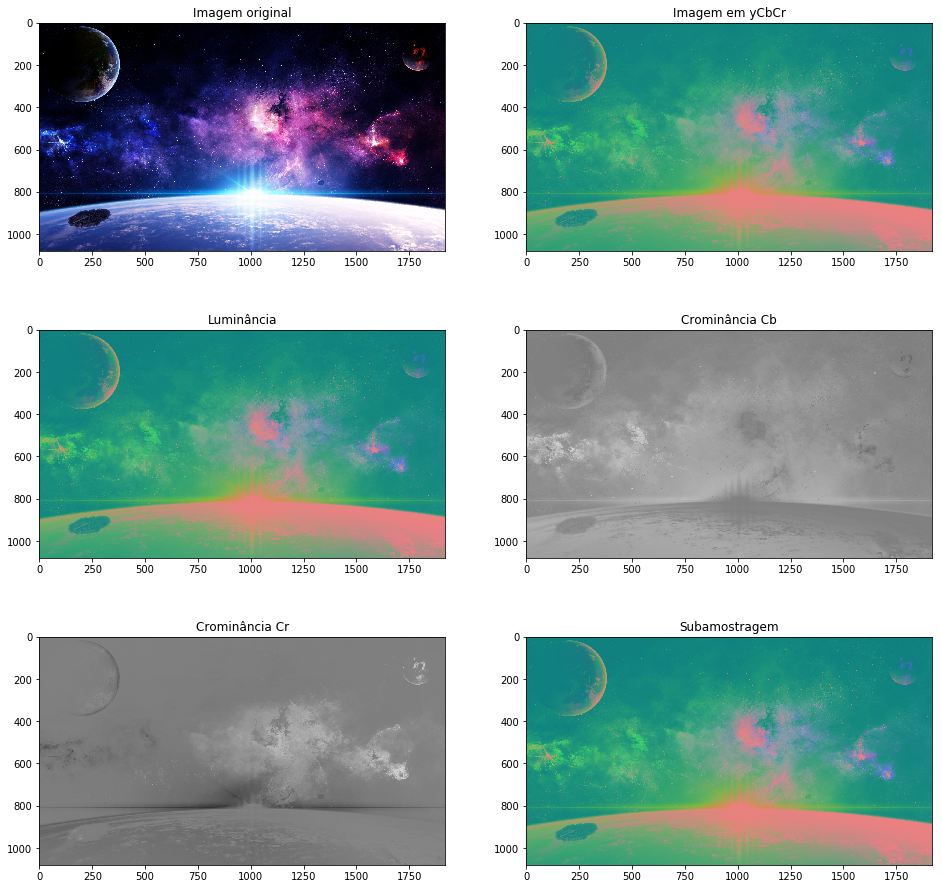

In [35]:
# Exibindo imagens

plt.figure(figsize = (16, 16))

plt.subplot(3, 2, 1)
plt.title('Imagem original')
plt.imshow(img)

plt.subplot(3, 2, 2)
plt.title('Imagem em yCbCr')
plt.imshow(img_yCbCr)

plt.subplot(3, 2, 3)
plt.title('Luminância')
plt.imshow(img_y)

plt.subplot(3, 2, 4)
plt.title('Crominância Cb')
plt.imshow(img_Cb)

plt.subplot(3, 2, 5)
plt.title('Crominância Cr')
plt.imshow(img_Cr)

plt.subplot(3, 2, 6)
plt.title('Subamostragem')
plt.imshow(img_subsampling)

In [36]:
# Subamostragem de cada camada de cor
img_0 = img_subsampling[:, :, 0]
img_1 = img_subsampling[:, :, 1]
img_2 = img_subsampling[:, :, 2]

# Deslocar em 128 para esquerda
(l, c) = img_0.shape
for i in range(l):
    for j in range(c):
        img_0[i, j] -= 128
        img_1[i, j] -= 128
        img_2[i, j] -= 128

In [37]:
# DCT
img_dct_0 = scipy_dct(scipy_dct(img_0.T, norm='ortho').T, norm='ortho')
img_dct_1 = scipy_dct(scipy_dct(img_1.T, norm='ortho').T, norm='ortho')
img_dct_2 = scipy_dct(scipy_dct(img_2.T, norm='ortho').T, norm='ortho')

In [38]:
# Quantização
quantization_table = np.array(
    [[16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]])

img_quantized_0 = np.zeros(shape = img_dct_0.shape)
img_quantized_1 = np.zeros(shape = img_dct_0.shape)
img_quantized_2 = np.zeros(shape = img_dct_0.shape)

(l, c) = img_quantized_0.shape
block_size = 8
for i in range(0, l, 8):
    for j in range(0, c, 8):
        img_quantized_0[i:i + block_size, j:j + block_size] = quantization(img_dct_0[i:i + block_size, j:j + block_size], quantization_table)
        img_quantized_1[i:i + block_size, j:j + block_size] = quantization(img_dct_1[i:i + block_size, j:j + block_size], quantization_table)
        img_quantized_2[i:i + block_size, j:j + block_size] = quantization(img_dct_2[i:i + block_size, j:j + block_size], quantization_table)

In [39]:
# RLE_Encode
img_encoded_0 = rle_encode(img_quantized_0, l, c)
img_encoded_1 = rle_encode(img_quantized_1, l, c)
img_encoded_2 = rle_encode(img_quantized_2, l, c)

print("len img_encoded_0: ", len(img_encoded_0), " elements")
print("len img_encoded_1: ", len(img_encoded_1), " elements")
print("len img_encoded_2: ", len(img_encoded_2), " elements")

len img_encoded_0:  1979670  elements
len img_encoded_1:  1248596  elements
len img_encoded_2:  2332238  elements


In [40]:
# Huffman
# https://pypi.org/project/huffman/
import huffman
import collections

huffman_dict_0 = huffman.codebook(collections.Counter(img_encoded_0).items())
huffman_dict_1 = huffman.codebook(collections.Counter(img_encoded_1).items())
huffman_dict_2 = huffman.codebook(collections.Counter(img_encoded_2).items())

huffman_0 = ""
huffman_1 = ""
huffman_2 = ""

for value in img_encoded_0:
    huffman_0 += huffman_dict_0[value]
    
for value in img_encoded_1:
    huffman_1 += huffman_dict_1[value]
    
for value in img_encoded_2:
    huffman_2 += huffman_dict_2[value]
    
print("len huffman_0: ", len(huffman_0), " bits, ", len(huffman_0) / 8, " bytes, ", (len(huffman_0) / 8) / 1000, "kB")
print("len huffman_1: ", len(huffman_1), " bits, ", len(huffman_1) / 8, " bytes, ", (len(huffman_1) / 8) / 1000, "kB")
print("len huffman_2: ", len(huffman_2), " bits, ", len(huffman_2) / 8, " bytes, ", (len(huffman_2) / 8) / 1000, "kB")

print("total size: ", ((len(huffman_0) / 8) / 1000) + ((len(huffman_1) / 8) / 1000) + ((len(huffman_2) / 8) / 1000), "kB")

len huffman_0:  5440019  bits,  680002.375  bytes,  680.002375 kB
len huffman_1:  3645482  bits,  455685.25  bytes,  455.68525 kB
len huffman_2:  6375948  bits,  796993.5  bytes,  796.9935 kB
total size:  1932.681125 kB


In [41]:
# Huffman Decode
def huffmanDecode(dictionary, data):
    output = []
    
    while data:
        for symbol, code in dictionary.items():
            if data.startswith(code):
                output.append(symbol)
                
                data = data[len(code):]
                
    return output

img_decoded_0 = huffmanDecode(huffman_dict_0, huffman_0)
img_decoded_1 = huffmanDecode(huffman_dict_1, huffman_1)
img_decoded_2 = huffmanDecode(huffman_dict_2, huffman_2)

In [42]:
# RLE_Decode
img_decoded_0 = rle_decode(img_decoded_0, l, c)
img_decoded_1 = rle_decode(img_decoded_1, l, c)
img_decoded_2 = rle_decode(img_decoded_2, l, c)

In [43]:
# Desquantização
img_reverse_quantized_0 = np.zeros(shape = img_decoded_0.shape)
img_reverse_quantized_1 = np.zeros(shape = img_decoded_0.shape)
img_reverse_quantized_2 = np.zeros(shape = img_decoded_0.shape)

(l, c) = img_reverse_quantized_0.shape
block_size = 8
for i in range(0, l, 8):
    for j in range(0, c, 8):
        img_reverse_quantized_0[i:i + block_size, j:j + block_size] = reverse_quantization(img_decoded_0[i:i + block_size, j:j + block_size], quantization_table)
        img_reverse_quantized_1[i:i + block_size, j:j + block_size] = reverse_quantization(img_decoded_1[i:i + block_size, j:j + block_size], quantization_table)
        img_reverse_quantized_2[i:i + block_size, j:j + block_size] = reverse_quantization(img_decoded_2[i:i + block_size, j:j + block_size], quantization_table)

In [44]:
# IDCT
l, c = img_reverse_quantized_0.shape

img_idct_0 = scipy_idct(scipy_idct(img_reverse_quantized_0.T, norm='ortho').T, norm='ortho')
img_idct_1 = scipy_idct(scipy_idct(img_reverse_quantized_1.T, norm='ortho').T, norm='ortho')
img_idct_2 = scipy_idct(scipy_idct(img_reverse_quantized_2.T, norm='ortho').T, norm='ortho')

In [45]:
# Deslocar em 128 para direita
l, c = img_idct_0.shape

almost_there_0 = np.zeros(shape=(l, c))
almost_there_1 = np.zeros(shape=(l, c))
almost_there_2 = np.zeros(shape=(l, c))

for i in range(l):
    for j in range(c):
        almost_there_0[i, j] = img_idct_0[i, j] + 128
        almost_there_1[i, j] = img_idct_1[i, j] + 128
        almost_there_2[i, j] = img_idct_2[i, j] + 128

In [46]:
# Juntando as camadas de cores
finally_jpeg_image = np.zeros(shape = (l, c, 3), dtype=np.uint8)
finally_jpeg_image[:, :, 0] = almost_there_0
finally_jpeg_image[:, :, 1] = almost_there_1
finally_jpeg_image[:, :, 2] = almost_there_2

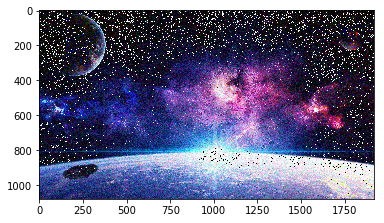

In [47]:
# Convertendo cores yCbCr para RGB
finally_jpeg_image = convert_yCbCr_rgb(finally_jpeg_image)
plt.imshow(finally_jpeg_image)

In [48]:
# Salvando a imagem nova
img_pil = Image.fromarray(finally_jpeg_image)
img_pil.save(img_new_name)

In [49]:
img_compressed = np.array(Image.open(img_new_name))

print('tamanho em bytes img original: ',img.nbytes)
print('tamanho em bytes img comprimida: ',img_compressed.nbytes)
print('taxa de compressão: ',img.nbytes/img_compressed.nbytes)

tamanho em bytes img original:  8294400
tamanho em bytes img comprimida:  6220800
taxa de compressão:  1.3333333333333333


In [50]:
#https://web.archive.org/web/20180421030430/http://www.equasys.de/colorconversion.html

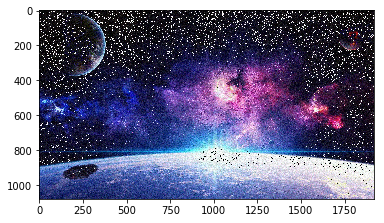

In [51]:
plt.imshow(img_compressed)